this notebook attempts to train a simple baseline (linear regression) for forecasting of Covid19 infections and deaths
worldwide

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read the data
data = pd.read_csv('../data/data_preprocessed.csv')

In [3]:
data.head()

Province_State      Country        Date  Infections  Fatalities  \
0           None  Afghanistan  2020-01-22         0.0         0.0   
1           None  Afghanistan  2020-01-23         0.0         0.0   
2           None  Afghanistan  2020-01-24         0.0         0.0   
3           None  Afghanistan  2020-01-25         0.0         0.0   
4           None  Afghanistan  2020-01-26         0.0         0.0   

   % of worldpopulation  Age_0_to_14  Age_15_to_64  Age_over_65   Day  Month  
0               0.00415        0.432         0.542        0.026  22.0    1.0  
1               0.00415        0.432         0.542        0.026  23.0    1.0  
2               0.00415        0.432         0.542        0.026  24.0    1.0  
3               0.00415        0.432         0.542        0.026  25.0    1.0  
4               0.00415        0.432         0.542        0.026  26.0    1.0

In [4]:
# keep original data as ground truth for plotting predictions versus actual values later on
data_actual = data.copy()
# get only test dates
data_actual = data_actual[data_actual['Date'] >= '2020-03-18']
# combine country and province_state
data_actual['Country'] = data_actual['Country']  + "_" + data_actual['Province_State']
data_actual['Country'] = data_actual['Country'].str.replace("_None", "")
data_actual = data_actual.drop('Province_State', axis=1)

In [5]:
# OPTIONAL: log transform dependent variables
data['Infections'][data['Infections'] == 0] = 1
data['Fatalities'][data['Fatalities'] == 0] = 1

data['Infections'] = np.log(data['Infections'])
data['Fatalities'] = np.log(data['Fatalities'])

d:\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<h2> Data preparation stage

for a linear regression forecasting model, all dependent variables (Infections and Fatalities) up until a certain time 
together must be concatenated

In [6]:
# The testing data on Kaggle is from the time period: 2020-03-19 - 2020-04-01
# Therefore, training data should go up to but excluding 2020-03-19
# Then, the final date in the training set can be used as the labels: 2020-03-18
# The data starts on 22-01-2020, so the linear regression works on a time-window of 57 days
# days to forecast ahead: 2020-03-18 ---> 2020-04-01, which is 15 days

In [7]:
# take the Infections and Fatalities from 2020-03-18 as labels
labels = data[data['Date'] == '2020-03-18'][['Infections', 'Fatalities']]

In [8]:
# remove data from 2020-03-18 on
data = data[data['Date'] < '2020-03-18']

In [9]:
# Date column is now no longer needed; drop from dataframe
data = data.drop(['Date', 'Month', 'Day'], axis=1)
data.head()

Province_State      Country  Infections  Fatalities  % of worldpopulation  \
0           None  Afghanistan         0.0         0.0               0.00415   
1           None  Afghanistan         0.0         0.0               0.00415   
2           None  Afghanistan         0.0         0.0               0.00415   
3           None  Afghanistan         0.0         0.0               0.00415   
4           None  Afghanistan         0.0         0.0               0.00415   

   Age_0_to_14  Age_15_to_64  Age_over_65  
0        0.432         0.542        0.026  
1        0.432         0.542        0.026  
2        0.432         0.542        0.026  
3        0.432         0.542        0.026  
4        0.432         0.542        0.026

In [10]:
# combine different Provinces/states together with the Country column for easier identification 
data['Country_with_state'] = data['Country']  + "_" + data['Province_State']

In [11]:
# remove "_None" suffix
data['Country_with_state'] = data['Country_with_state'].str.replace("_None", "")
# remove Province_State and Country columns, replace with 'Country_with_state' column
data = data.drop(['Province_State', 'Country'], axis=1)
data = data.rename(columns={'Country_with_state': 'Country'})
data.head()

Infections  Fatalities  % of worldpopulation  Age_0_to_14  Age_15_to_64  \
0         0.0         0.0               0.00415        0.432         0.542   
1         0.0         0.0               0.00415        0.432         0.542   
2         0.0         0.0               0.00415        0.432         0.542   
3         0.0         0.0               0.00415        0.432         0.542   
4         0.0         0.0               0.00415        0.432         0.542   

   Age_over_65      Country  
0        0.026  Afghanistan  
1        0.026  Afghanistan  
2        0.026  Afghanistan  
3        0.026  Afghanistan  
4        0.026  Afghanistan

In [12]:
# define a function that takes, for a specific country, the infections and fatalities, then transposes them and
# makes columns out of each day
def transpose_to_columns(data):
    # transpose infections and fatalities columns
    infections_transposed = pd.DataFrame(data['Infections']).reset_index(drop=True).transpose().reset_index(drop=True)
    fatalities_transposed = pd.DataFrame(data['Fatalities']).reset_index(drop=True).transpose().reset_index(drop=True)
    
    # add appropriate suffix
    df_infections = pd.DataFrame(infections_transposed).add_prefix('Infections_day_')
    df_fatalities = pd.DataFrame(fatalities_transposed).add_prefix('Fatalities_day_')
    # add country as column for merging
    df_infections['Country'] = data.Country.iloc[0]
    
    # concatenate both together
    df = pd.concat([df_infections, df_fatalities], axis=1)
    
    return df
    

# define a function that appends to each country the Fatalities and Infections as columns
def concatenate_infections_and_deaths(data):
    new_rows = []
    for country in data['Country'].unique():
        # take data from current country
        data_country = data[data['Country'] == country]
        # get the infections and fatalities as columns for current country
        data_infec_fatal = transpose_to_columns(data_country)
        # merge with other columns by Country and drop 'Infections' and 'Fatalities'
        data_country = pd.merge(data_country.drop(['Infections', 'Fatalities'], axis=1), data_infec_fatal, on="Country")
        column_names = data_country.columns
        # Since each country+province has the same features, keep only one row
        new_rows.append(data_country.iloc[0, :])
        
    return pd.DataFrame(new_rows, columns=column_names)

In [13]:
data = concatenate_infections_and_deaths(data).set_index('Country')
data.head()

% of worldpopulation  Age_0_to_14  Age_15_to_64  \
Country                                                                
Afghanistan                      0.004150        0.432         0.542   
Albania                          0.000368        0.174         0.689   
Algeria                          0.005530        0.293         0.645   
Angola                           0.004000        0.468         0.508   
Antigua and Barbuda              0.000012        0.239         0.692   

                     Age_over_65  Infections_day_0  Infections_day_1  \
Country                                                                
Afghanistan                0.026               0.0               0.0   
Albania                    0.132               0.0               0.0   
Algeria                    0.062               0.0               0.0   
Angola                     0.024               0.0               0.0   
Antigua and Barbuda        0.069               0.0               0.0   

                     Infections_day_2  Infections_day_3  Infections_day_4  \
Country                                                                     
Afghanistan                       0.0               0.0               0.0   
Albania                           0.0               0.0               0.0   
Algeria                           0.0               0.0               0.0   
Angola                            0.0               0.0               0.0   
Antigua and Barbuda               0.0               0.0               0.0   

                     Infections_day_5  ...  Fatalities_day_46  \
Country                                ...                      
Afghanistan                       0.0  ...                0.0   
Albania                           0.0  ...                0.0   
Algeria                           0.0  ...                0.0   
Angola                            0.0  ...                0.0   
Antigua and Barbuda               0.0  ...                0.0   

                     Fatalities_day_47  Fatalities_day_48  Fatalities_day_49  \
Country                                                                        
Afghanistan                        0.0                0.0                0.0   
Albania                            0.0                0.0                0.0   
Algeria                            0.0                0.0                0.0   
Angola                             0.0                0.0                0.0   
Antigua and Barbuda                0.0                0.0                0.0   

                     Fatalities_day_50  Fatalities_day_51  Fatalities_day_52  \
Country                                                                        
Afghanistan                        0.0           0.000000           0.000000   
Albania                            0.0           0.000000           0.000000   
Algeria                            0.0           0.693147           1.098612   
Angola                             0.0           0.000000           0.000000   
Antigua and Barbuda                0.0           0.000000           0.000000   

                     Fatalities_day_53  Fatalities_day_54  Fatalities_day_55  
Country                                                                       
Afghanistan                   0.000000           0.000000           0.000000  
Albania                       0.000000           0.000000           0.000000  
Algeria                       1.386294           1.386294           1.386294  
Angola                        0.000000           0.000000           0.000000  
Antigua and Barbuda           0.000000           0.000000           0.000000  

[5 rows x 116 columns]

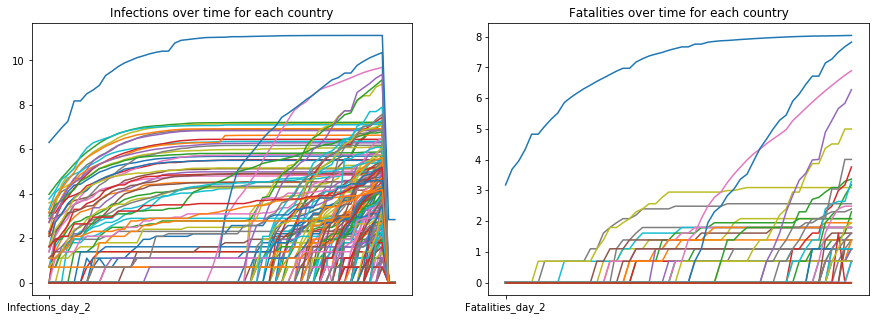

In [14]:
# check if data so far is correct by plotting infections and fatalities worldwide over time
fig, (ax, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
ax.set_title('Infections over time for each country')
ax.set_xticks([0])
data.iloc[:, 6:62].transpose().plot(ax=ax)
ax.get_legend().remove()

ax2.set_title('Fatalities over time for each country')
ax2.set_xticks([0])
data.iloc[:, 62:].transpose().plot(ax=ax2)
ax2.get_legend().remove()

In [15]:
# verify data and labels shape
data.shape, labels.shape

((224, 116), (224, 2))

Now each country + optional state/province is represented only once in the dataset, with each infection and fatality number as columns (in addition to other information such as population and age distribution). The labels contain the infection and fatality number for 2020-03-18, which is one day further than the final day in the data

<h2> Modelling stage

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

In [17]:
# use cross-validation to split the data into training and validation data

In [18]:
from sklearn.metrics import r2_score
from sklearn.base import clone

def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    y_pred[y_pred < 0] = 0
    y_test[y_test < 0] = 0
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

def cross_validate(data, labels, model, n_splits=10):
    splitter = KFold(n_splits=n_splits)
    if(n_splits < len(data)):
        score_r2_avg = 0
    score_rmsle_avg = 0
    for train_idx, test_idx in splitter.split(data):      
        model = clone(model)
        
        # define train and test data
        x_train = data[train_idx]
        y_train = labels[train_idx]
        
        x_test = data[test_idx]
        y_test = labels[test_idx]
        
        # fit model on train data, evaluate on test data
        model.fit(x_train, y_train)
        preds = np.exp(model.predict(x_test))
        if(n_splits < len(data)):
            score_r2_fold = r2_score(preds, np.exp(y_test))
        score_rmsle_fold = rmsle(preds, np.exp(y_test))
        
        #print("R2 score: {0}".format(score_r2_fold))
        #print("RMSLE score: {0}\n".format(score_rmsle_fold))
        
        if(n_splits < len(data)):
            score_r2_avg += score_r2_fold
        score_rmsle_avg += score_rmsle_fold
    if(n_splits < len(data)):
        print("\nAverage R2 score:", score_r2_avg / n_splits)
    print("Average RMSLE score:", score_rmsle_avg / n_splits)

In [19]:
# shuffle data before cross-validation
from sklearn.utils import shuffle

data_shuffled, labels_shuffled = shuffle(data, labels) 

In [20]:
parameters = [0.1, 0.5, 1, 2, 3, 5, 10, 20, 30, 40, 50, 100]

In [21]:
# apply k-fold cross-validation
for i in range(len(parameters)):
    model = Ridge(alpha=parameters[i])
    print('---------Alpha: {0}------------\n'.format(parameters[i]))
    cross_validate(data_shuffled.values, labels_shuffled.values, model=model, n_splits=10)

---------Alpha: 0.1------------


Average R2 score: 0.91136624095834
Average RMSLE score: 0.17468151362520082
---------Alpha: 0.5------------


Average R2 score: 0.9515542136581352
Average RMSLE score: 0.15944858297869863
---------Alpha: 1------------


Average R2 score: 0.9567076309766429
Average RMSLE score: 0.15659938304745402
---------Alpha: 2------------


Average R2 score: 0.9608415150868416
Average RMSLE score: 0.15554851604185724
---------Alpha: 3------------


Average R2 score: 0.9630697360265016
Average RMSLE score: 0.1560296788212764
---------Alpha: 5------------


Average R2 score: 0.9649556377982014
Average RMSLE score: 0.15832400217311882
---------Alpha: 10------------


Average R2 score: 0.9632365027655622
Average RMSLE score: 0.16556788713902576
---------Alpha: 20------------


Average R2 score: 0.950687709468283
Average RMSLE score: 0.17921169344241872
---------Alpha: 30------------


Average R2 score: 0.9341427224560845
Average RMSLE score: 0.19107083480505416
-------

In [22]:
# apply Leave-One-Out cross-validation (can't be used for R2 score)
for i in range(len(parameters)):
    print("Alpha:", parameters[i])
    model = Ridge(alpha=parameters[i])
    cross_validate(data.values, labels.values, model=model, n_splits=len(data))

Alpha: 0.1
Average RMSLE score: 0.13120675688626873
Alpha: 0.5
Average RMSLE score: 0.11925082174574177
Alpha: 1
Average RMSLE score: 0.11658328043319555
Alpha: 2
Average RMSLE score: 0.1157502333575839
Alpha: 3
Average RMSLE score: 0.11591356255746452
Alpha: 5
Average RMSLE score: 0.11754799904348402
Alpha: 10
Average RMSLE score: 0.1234157158047723
Alpha: 20
Average RMSLE score: 0.13552240026630114
Alpha: 30
Average RMSLE score: 0.1459657159689606
Alpha: 40
Average RMSLE score: 0.15491081942201676
Alpha: 50
Average RMSLE score: 0.1627270318984627
Alpha: 100
Average RMSLE score: 0.19310546228839137


In [23]:
# select final model for forecasting

#model = LinearRegression()
#model = RandomForestRegressor() 
model = Ridge(alpha=2)

In [24]:
# fit model on all data
model.fit(data, labels)

Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [25]:
coefs_infection = model.coef_[0]
coefs_fatality = model.coef_[1]

In [26]:
coefs_sorted_idx = np.argsort(coefs_infection)
# get top 10 highest coefs
top10_high = coefs_sorted_idx[-10:]
# get top 10 lowest coefs
top10_low = coefs_sorted_idx[:10]

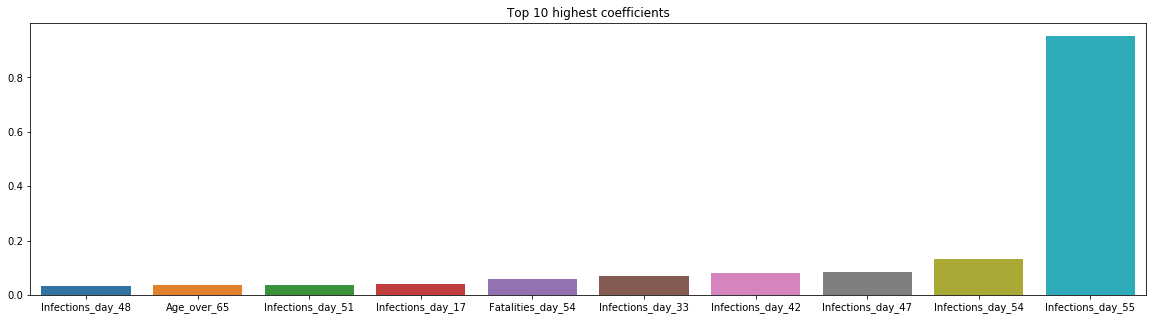

In [27]:
# make barchart of both top5's
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 5)
ax.set_title('Top 10 highest coefficients')
sns.barplot(data.columns[top10_high], coefs_infection[top10_high])

It seems that the final timestep in the data, 'infections_day_55', is assigned the highest weight.

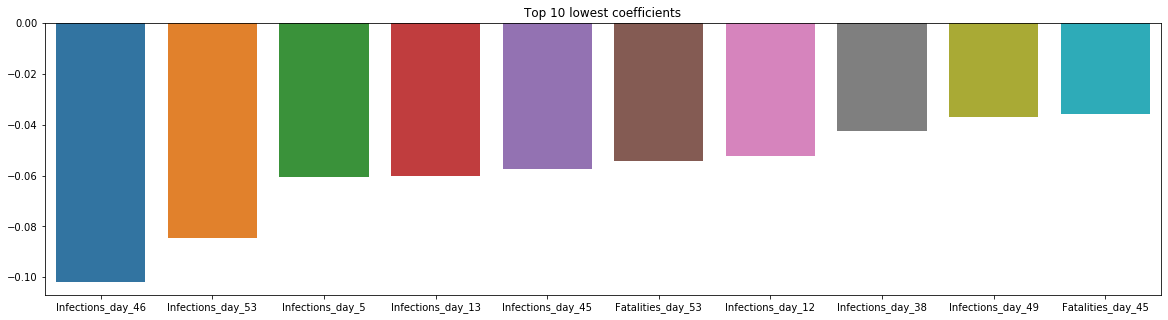

In [28]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 5)
ax.set_title('Top 10 lowest coefficients')
sns.barplot(data.columns[top10_low], coefs_infection[top10_low])

It seems that information regarding age distribution is assigned a large weight by the model.

In [29]:
# store model weights to disk for forecasting
#from joblib import dump, load
#dump(model, '../models/lr.joblib')

In [30]:
# test the loading function
#model = load('../models/lr.joblib')

In [31]:
#model.score(data, labels)

<h2> Testing stage

In [32]:
data.head()

% of worldpopulation  Age_0_to_14  Age_15_to_64  \
Country                                                                
Afghanistan                      0.004150        0.432         0.542   
Albania                          0.000368        0.174         0.689   
Algeria                          0.005530        0.293         0.645   
Angola                           0.004000        0.468         0.508   
Antigua and Barbuda              0.000012        0.239         0.692   

                     Age_over_65  Infections_day_0  Infections_day_1  \
Country                                                                
Afghanistan                0.026               0.0               0.0   
Albania                    0.132               0.0               0.0   
Algeria                    0.062               0.0               0.0   
Angola                     0.024               0.0               0.0   
Antigua and Barbuda        0.069               0.0               0.0   

                     Infections_day_2  Infections_day_3  Infections_day_4  \
Country                                                                     
Afghanistan                       0.0               0.0               0.0   
Albania                           0.0               0.0               0.0   
Algeria                           0.0               0.0               0.0   
Angola                            0.0               0.0               0.0   
Antigua and Barbuda               0.0               0.0               0.0   

                     Infections_day_5  ...  Fatalities_day_46  \
Country                                ...                      
Afghanistan                       0.0  ...                0.0   
Albania                           0.0  ...                0.0   
Algeria                           0.0  ...                0.0   
Angola                            0.0  ...                0.0   
Antigua and Barbuda               0.0  ...                0.0   

                     Fatalities_day_47  Fatalities_day_48  Fatalities_day_49  \
Country                                                                        
Afghanistan                        0.0                0.0                0.0   
Albania                            0.0                0.0                0.0   
Algeria                            0.0                0.0                0.0   
Angola                             0.0                0.0                0.0   
Antigua and Barbuda                0.0                0.0                0.0   

                     Fatalities_day_50  Fatalities_day_51  Fatalities_day_52  \
Country                                                                        
Afghanistan                        0.0           0.000000           0.000000   
Albania                            0.0           0.000000           0.000000   
Algeria                            0.0           0.693147           1.098612   
Angola                             0.0           0.000000           0.000000   
Antigua and Barbuda                0.0           0.000000           0.000000   

                     Fatalities_day_53  Fatalities_day_54  Fatalities_day_55  
Country                                                                       
Afghanistan                   0.000000           0.000000           0.000000  
Albania                       0.000000           0.000000           0.000000  
Algeria                       1.386294           1.386294           1.386294  
Angola                        0.000000           0.000000           0.000000  
Antigua and Barbuda           0.000000           0.000000           0.000000  

[5 rows x 116 columns]

In [33]:
# get start and end column index of both infections and fatalities
start_infections = np.where(data.head().columns == 'Infections_day_0')[0][0]
end_infections = np.where(data.head().columns == 'Infections_day_55')[0][0]

start_fatalities = np.where(data.head().columns == 'Fatalities_day_0')[0][0]
end_fatalities = np.where(data.head().columns == 'Fatalities_day_55')[0][0]

start_infections, end_infections, start_fatalities, end_fatalities

(4, 59, 60, 115)

In [34]:
# Forecasting process:
# 1: predict for each row the infections and fatalities of the next day
# 2: separate infections and fatality columns
# 3: append fatalities and infections columns with latest predictions
# 4: shift window
# 5: concatenate data back together
# 6: repeat until predictions of final day (01-04-2020) have been made

In [35]:
# define a function that uses a forecasting window to predict a certain number of days ahead
def forecast_sliding_window(data, model, n_days_ahead, start_idx_inf, start_idx_fat, end_idx_inf, end_idx_fat):
    current_day = 55
    # 6: repeat until predictions of final day (01-04-2020) have been made
    for i in range(n_days_ahead):
        # 1: predict for each row the infections and fatalities of the next day
        preds = model.predict(data)
        preds_inf = preds[:, 0]
        preds_fat = preds[:, 1]
        
        # 2: separate additional data, infections and fatality columns
        data_add = data[['% of worldpopulation', 'Age_0_to_14', 'Age_15_to_64', 'Age_over_65']]
        data_inf = data.iloc[:, start_idx_inf:end_idx_inf+1]
        data_fat = data.iloc[:, start_idx_fat:end_idx_fat+1]
        
        # 3: append fatalities and infections columns with latest predictions
        data_inf = pd.concat([data_inf, pd.Series(preds_inf,
                                                  index=data_inf.index, 
                                                  name='Infections_day_' + str(current_day + 1))], axis=1)
        data_fat = pd.concat([data_fat, pd.Series(preds_fat,
                                                  index=data_fat.index,
                                                  name='Fatalities_day_' + str(current_day + 1))], axis=1)
       
        # 4: shift window
        data_inf = data_inf.iloc[:, 1:]
        data_fat = data_fat.iloc[:, 1:]
        
        # 5: concat data back together
        data = pd.concat([data_add, data_inf, data_fat], axis=1)
        
        current_day += 1
    
    return data
        

In [36]:
# set number of days to predict ahead
n_days_ahead = 13

In [37]:
data_forecast = forecast_sliding_window(data, 
                                        model,
                                        n_days_ahead=n_days_ahead,
                                        start_idx_inf=start_infections,
                                        start_idx_fat=start_fatalities,
                                        end_idx_inf=end_infections, 
                                        end_idx_fat=end_fatalities)

In [38]:
# select a country for plotting predictions versus actual values
country_plot = "Netherlands"

In [39]:
# convert predictions back from log scale using exponential function
preds_inf = np.exp(data_forecast[data_forecast.index == country_plot].iloc[:, start_infections:end_infections])
# take only the predicted next 2 weeks
preds_inf = preds_inf.iloc[:, -14:]
# transpose to easily get the actual predictions per day
preds_inf = preds_inf.transpose()

In [40]:
preds_fat = np.exp(data_forecast[data_forecast.index == country_plot].iloc[:, start_fatalities:end_fatalities])
preds_fat = preds_fat.iloc[:, -14:]
preds_fat = preds_fat.transpose()

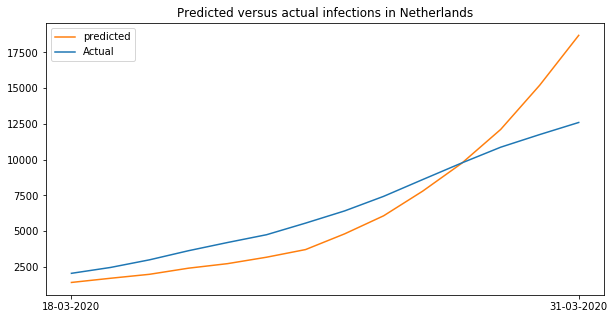

In [41]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,5)
preds_inf.plot(ax=ax, C='C1')
data_actual['Infections'][data_actual.Country == country_plot].reset_index(drop=True).plot(ax=ax, C='C0')
ax.set_xticks([0, 13])
ax.set_xticklabels(['18-03-2020', '31-03-2020'])
plt.legend(['predicted', 'Actual'])
ax.set_title("Predicted versus actual infections in {0}".format(country_plot))
plt.savefig('../images/infections_ridge_nl')

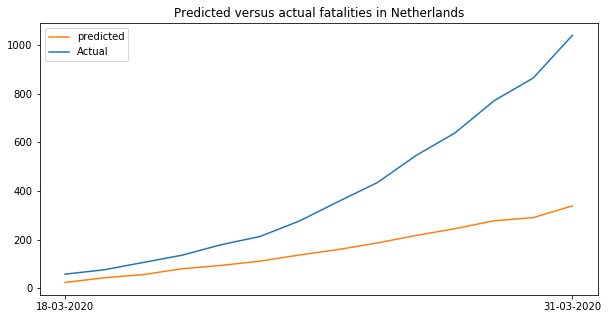

In [42]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,5)
preds_fat.plot(ax=ax, c='C1')
data_actual['Fatalities'][data_actual.Country == country_plot].reset_index(drop=True).plot(ax=ax, c='C0')
ax.set_xticks([0, 13])
ax.set_xticklabels(['18-03-2020', '31-03-2020'])
plt.legend(['predicted', 'Actual'])
ax.set_title("Predicted versus actual fatalities in {0}".format(country_plot))
plt.savefig('../images/fatalities_ridge_nl')

It seems that the Ridge regression model underestimates the number of fatalities and overestimates the number of infections in the Netherlands